In [1]:
import numpy as np # for linear algebra
import matplotlib.pyplot as plt # for plotting things
import os
from PIL import Image
print(os.listdir("input"))
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.metrics import Precision, Recall, AUC
import seaborn as sns


['chest_xray']


In [2]:
#defining folder parameters #print(mainDIR)
mainDIR = os.listdir('input/chest_xray/chest_xray')
train_folder= 'input/chest_xray/chest_xray/train/'
val_folder = 'input/chest_xray/chest_xray/val/'
test_folder = 'input/chest_xray/chest_xray/test/'
train_n = train_folder+'NORMAL/'
train_p = train_folder+'PNEUMONIA/'
val_n = val_folder+'NORMAL/'
val_p = val_folder+'PNEUMONIA/'
test_n = test_folder+'NORMAL/'
test_p = test_folder+'PNEUMONIA/'

print("nbr of normal pictures in trainingset: " + str(len(os.listdir(train_n))))
print("nbr of sick pictures in trainingset: " + str(len(os.listdir(train_p))))
print("nbr of normal pictures in testset: " + str(len(os.listdir(test_n))))
print("nbr of sick pictures in testset: " + str(len(os.listdir(test_p))))
print("nbr of normal pictures in validationset: " + str(len(os.listdir(val_n))))
print("nbr of sick pictures in validationset: " + str(len(os.listdir(val_p))))

nbr of normal pictures in trainingset: 1342
nbr of sick pictures in trainingset: 3876
nbr of normal pictures in testset: 234
nbr of sick pictures in testset: 390
nbr of normal pictures in validationset: 9
nbr of sick pictures in validationset: 9


random normal picture :  NORMAL2-IM-1033-0001.jpeg
random sick picture : person1491_bacteria_3892.jpeg
Normal Image Size: (1530, 1272)
Pneumonia Image Size: (1328, 968)
Image Mode normal image: L
Image Mode sick image: L


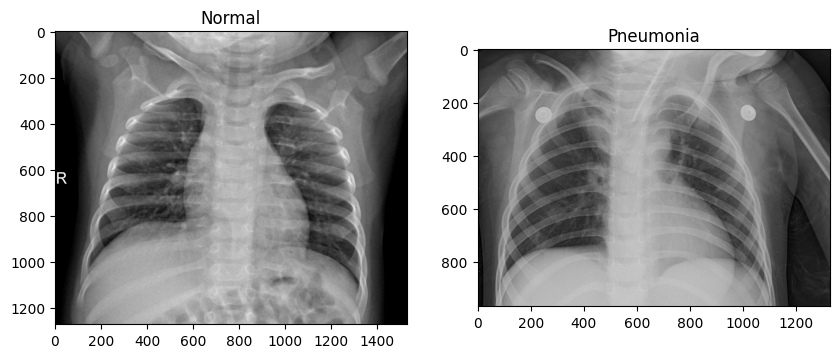

In [3]:
# analysing random training data #
# Normal pic 
rand_norm= np.random.randint(0,len(os.listdir(train_n)))
norm_pic = os.listdir(train_n)[rand_norm]
print('random normal picture : ',norm_pic)
norm_pic_address = train_n+norm_pic
norm_load = Image.open(norm_pic_address)
f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(norm_load, cmap='gray')
a1.set_title('Normal')
#Pneumonia 
rand_p = np.random.randint(0,len(os.listdir(train_p)))
sic_pic =  os.listdir(train_p)[rand_norm]
sic_address = train_p+sic_pic
print('random sick picture :', sic_pic)
sic_load = Image.open(sic_address)
a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(sic_load, cmap='gray')
a2.set_title('Pneumonia');
# Size
print("Normal Image Size:", norm_load.size)  # Output (width, height)
print("Pneumonia Image Size:", sic_load.size)
# Get mode (color format) # L is one channel
print("Image Mode normal image:", norm_load.mode) 
print("Image Mode sick image:", sic_load.mode)

In [4]:
folder_path =(train_n, train_p, val_n, val_p, test_n, test_p)
widths = []
heights = []
for i in folder_path:
    for filename in os.listdir(i):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):  # Check for image files
            img_path = os.path.join(i, filename)
            with Image.open(img_path) as img:
                width, height = img.size  # Get image size
                widths.append(width)
                heights.append(height)
    avg_width = np.mean(widths)
    avg_height = np.mean(heights)
    print(f"Average Image Size in {i}: {avg_width:.2f} x {avg_height:.2f} pixels (Aspect Ratio: {avg_width/avg_height:.2f})")

Average Image Size in input/chest_xray/chest_xray/train/NORMAL/: 1667.73 x 1381.43 pixels (Aspect Ratio: 1.21)
Average Image Size in input/chest_xray/chest_xray/train/PNEUMONIA/: 1320.61 x 968.07 pixels (Aspect Ratio: 1.36)
Average Image Size in input/chest_xray/chest_xray/val/NORMAL/: 1320.85 x 968.42 pixels (Aspect Ratio: 1.36)
Average Image Size in input/chest_xray/chest_xray/val/PNEUMONIA/: 1320.70 x 968.18 pixels (Aspect Ratio: 1.36)
Average Image Size in input/chest_xray/chest_xray/test/NORMAL/: 1341.23 x 985.34 pixels (Aspect Ratio: 1.36)
Average Image Size in input/chest_xray/chest_xray/test/PNEUMONIA/: 1327.88 x 970.69 pixels (Aspect Ratio: 1.37)


In [5]:
#mageDataGenerator augments your image by iterating through image
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = False) 

training_set = train_datagen.flow_from_directory(train_folder,
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 color_mode='grayscale',
                                                 shuffle=True,
                                                 class_mode = 'binary')

rescaled_set = ImageDataGenerator(rescale = 1./255) #Image normalization

validation_generator = rescaled_set.flow_from_directory(val_folder,
    target_size=(64, 64),
    batch_size=32,
    color_mode='grayscale',
    class_mode='binary')

test_set = rescaled_set.flow_from_directory(test_folder,
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            color_mode='grayscale',
                                            class_mode = 'binary',
                                            shuffle=False)  # Ensure consistency

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
input_shape = (64, 64, 1)  #input_shape=(img_rows, img_cols, 1)
cnn = Sequential()
cnn.add(Input(shape = input_shape))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=input_shape))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu"))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dropout(0.2))
#cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'sigmoid', units = 1))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy', Precision(), Recall(), AUC()])
cnn.summary()

c:\repos\Computer_vision\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,841 (61.88 KB)

 Trainable params: 15,841 (61.88 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Define early stopping
early_stop = EarlyStopping(
    monitor='val_loss',  # Stop when validation loss stops improving
    patience=5,  # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore the best model weights
)
# Train the model with early stopping
cnn_model = cnn.fit(
    training_set,
    epochs=50,  # Set a high number, but training will stop early if needed
    validation_data=validation_generator,
    callbacks=[early_stop]  # Attach early stopping
)

c:\repos\Computer_vision\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.7749 - auc: 0.6002 - loss: 0.5371 - precision: 0.7737 - recall: 0.9944 - val_accuracy: 0.6875 - val_auc: 0.8906 - val_loss: 0.5331 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.9031 - auc: 0.9529 - loss: 0.2483 - precision: 0.9178 - recall: 0.9548 - val_accuracy: 0.8750 - val_auc: 0.9375 - val_loss: 0.3492 - val_precision: 0.8750 - val_recall: 0.8750
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.9105 - auc: 0.9616 - loss: 0.2202 - precision: 0.9340 - recall: 0.9457 - val_accuracy: 0.8750 - val_auc: 0.9531 - val_loss: 0.3573 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.9150 - auc: 0.9693 - loss: 0.1998 - precision: 0.9349 - recall: 0.9510 - val_accuracy: 0.7500 - val_auc: 0.9375 - val_loss: 0.6560 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 5/50
163/163 ━

In [8]:
print(cnn_model.history.keys())

dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall'])


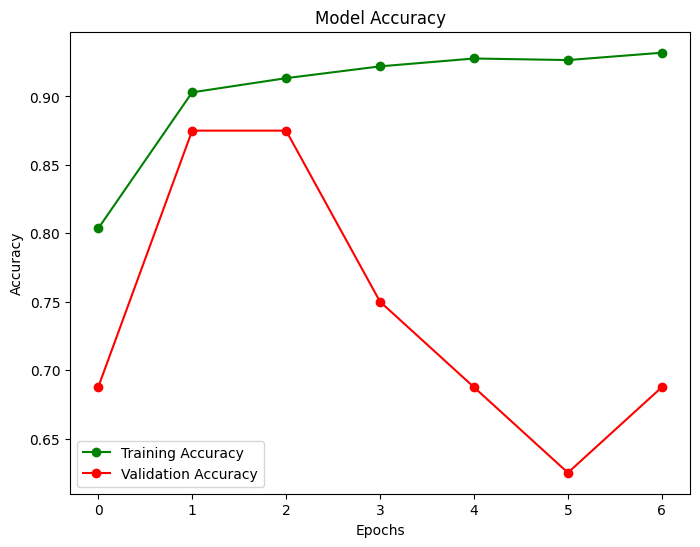

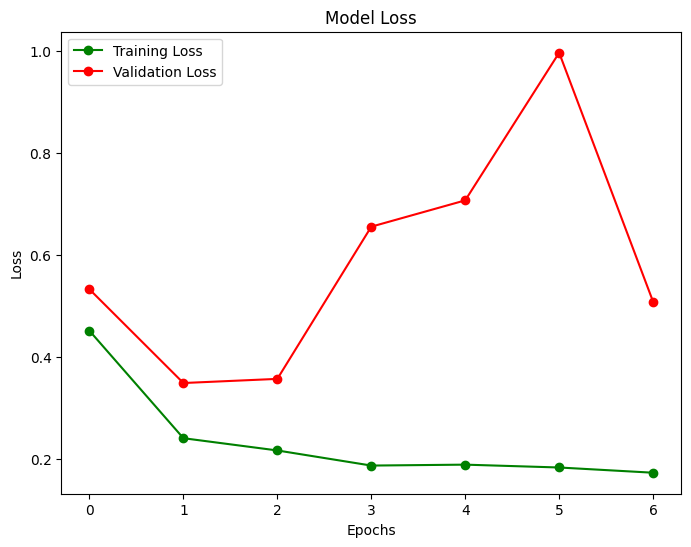

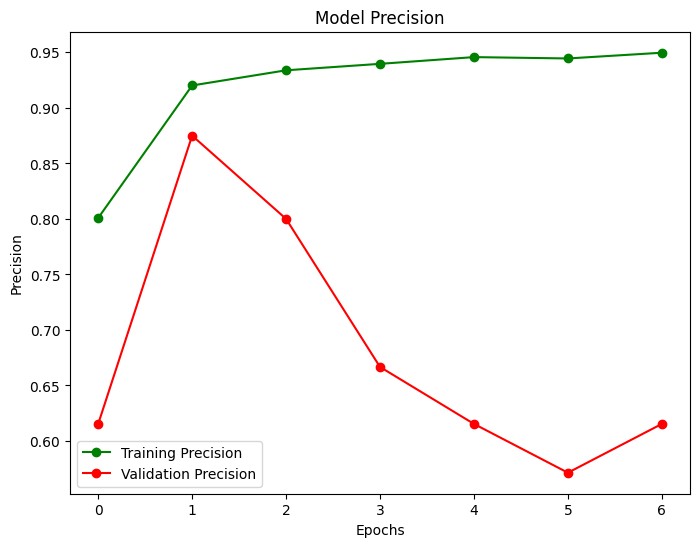

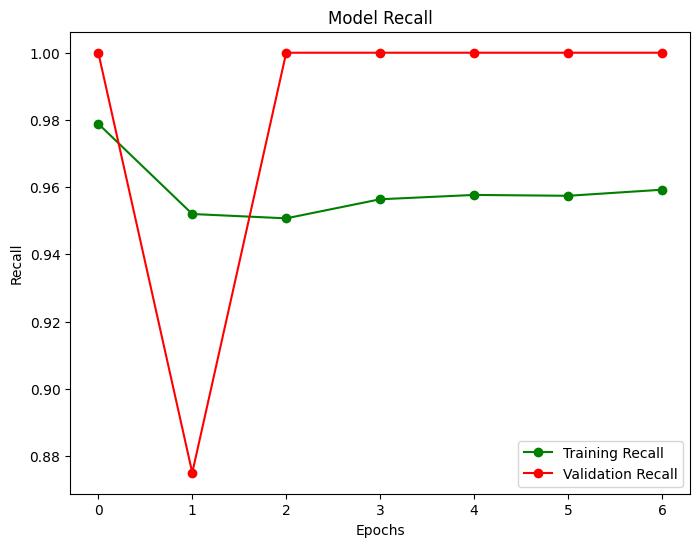

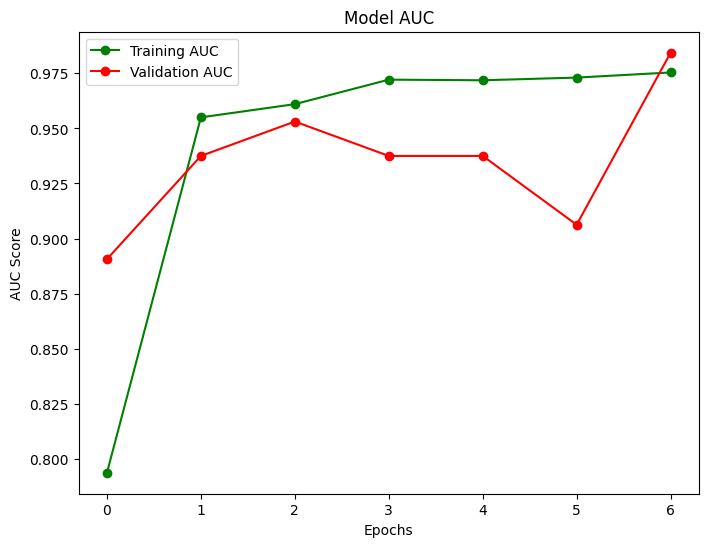

In [9]:
# Plot Accuracy
plt.figure(figsize=(8,6))
plt.plot(cnn_model.history['accuracy'], 'go-', label='Training Accuracy')
plt.plot(cnn_model.history['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# Plot Loss
plt.figure(figsize=(8,6))
plt.plot(cnn_model.history['loss'], 'go-', label='Training Loss')
plt.plot(cnn_model.history['val_loss'], 'ro-', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# Plot Precision
plt.figure(figsize=(8,6))
plt.plot(cnn_model.history['precision'], 'go-', label='Training Precision')
plt.plot(cnn_model.history['val_precision'], 'ro-', label='Validation Precision')
plt.title('Model Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()
# Plot Recall
plt.figure(figsize=(8,6))
plt.plot(cnn_model.history['recall'], 'go-', label='Training Recall')
plt.plot(cnn_model.history['val_recall'], 'ro-', label='Validation Recall')
plt.title('Model Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()
# Plot AUC
plt.figure(figsize=(8,6))
plt.plot(cnn_model.history['auc'], 'go-', label='Training AUC')
plt.plot(cnn_model.history['val_auc'], 'ro-', label='Validation AUC')
plt.title('Model AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC Score')
plt.legend()
plt.show()

In [15]:
loss, accuracy, precision, recall, auc = cnn.evaluate(test_set)
print(f"Test Loss: {loss:.2f}")
print(f"Test Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"AUC: {auc:.2f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.8632 - auc: 0.6379 - loss: 0.3037 - precision: 0.5114 - recall: 0.6153
Test Loss: 0.28
Test Accuracy: 0.88
Precision: 0.89
Recall: 0.91
AUC: 0.95


In [11]:
y_true = test_set.classes
print(y_true)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [12]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get predicted labels
prediction = cnn.predict(test_set)  # Predict on test set
print(prediction)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step
[[5.66231869e-02]
 [1.60249427e-01]
 [5.08502722e-01]
 [3.77014637e-01]
 [1.99924082e-01]
 [4.03477214e-02]
 [1.19460694e-01]
 [1.81505233e-01]
 [3.00152898e-01]
 [1.72874704e-01]
 [2.07742929e-01]
 [6.22767210e-01]
 [1.49788290e-01]
 [1.10458791e-01]
 [2.07058892e-01]
 [9.30537879e-02]
 [6.39072776e-01]
 [4.15908366e-01]
 [1.82769578e-02]
 [1.51369482e-01]
 [4.31840003e-01]
 [8.52151141e-02]
 [9.45882648e-02]
 [5.70835471e-02]
 [2.24651828e-01]
 [1.62278384e-01]
 [3.74054313e-01]
 [1.92755044e-01]
 [7.93205425e-02]
 [3.94781619e-01]
 [1.70207903e-01]
 [2.26664513e-01]
 [1.76760688e-01]
 [5.46345674e-02]
 [3.62175256e-01]
 [7.94215053e-02]
 [2.91045941e-03]
 [2.09228098e-01]
 [2.76805721e-02]
 [5.87102445e-03]
 [4.85341430e-01]
 [1.03761017e-01]
 [1.09785885e-01]
 [7.03935837e-03]
 [1.10000931e-01]
 [1.36260286e-01]
 [4.02784973e-01]
 [1.48237258e-01]
 [8.02509338e-02]
 [7.06432462e-01]
 [3.73137332e-02]
 [6.51058704e-02]
 [4.67036515e-01]
 [1.08

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step
Confusion Matrix:
 [[191  43]
 [ 34 356]]


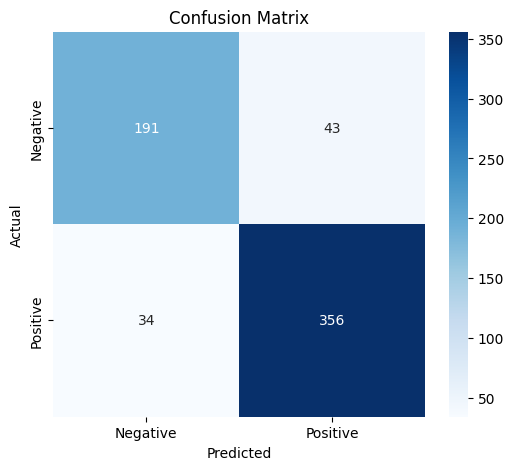

In [13]:
# Compute confusion matrix
y_true = test_set.classes

# Compute confusion matrix using evaluate()
y_pred_eval = (cnn.predict(test_set) > 0.5).astype(int).flatten()
cm = confusion_matrix(y_true, y_pred_eval)

print("Confusion Matrix:\n", cm)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [14]:
print(classification_report(y_true, y_pred_eval, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.85      0.82      0.83       234
    Positive       0.89      0.91      0.90       390

    accuracy                           0.88       624
   macro avg       0.87      0.86      0.87       624
weighted avg       0.88      0.88      0.88       624

